## Prototype for Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the performance of a new prototype method to calibrate lower confidence bounds for survival times under right-censoring.
This method used imputation of unobserved censoring times to obtain an artificial data set with type-I censoring, and then applies Candes' method.
The methods are implemented in the accompanying "utils" R scripts.

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)

## Generate a synthetic survival data set

We focus on Setting 8 from the paper. In this setting, fitting an accurate survival model is challenging, making rigorous conformal calibration essential difficult learning problem.

In [2]:
source("../conf_surv/utils_data.R")

## Definitions of Settings 1--3 from the paper (in decreasing order of intrinsic difficulty)
setting = 1

if(setting==1) {
    ## New setting
    ## Initialize the covariate model
    num_features <- 100
    covariate_generator <- function(num_samples) {
        matrix(runif(num_samples * num_features, 0, 1), nrow = num_samples)
    }
    ## Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + X[,1]^0.25
    surv_sigma_fun <- function(X) 0*X[,1] + 0.1
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)
    ## Initialize the censoring time distribution
    cens_mu_fun <- function(X) 0*X[,1] + X[,1]^4 + 0.4
    cens_sigma_fun <- function(X) 0*X[,1] + 0.1
    censoring_generator <- LogNormalDistribution$new(mu_fun = cens_mu_fun, sigma_fun = cens_sigma_fun)

} else if(setting==2) {
    ## New setting
    ## Initialize the covariate model
    num_features <- 100
    covariate_generator <- function(num_samples) {
        matrix(runif(num_samples * num_features, 0, 1), nrow = num_samples)
    }
    ## Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + (X[,2]>0.5) + (X[,3]<0.5) + (1-X[,1])^0.25
    surv_sigma_fun <- function(X) 0*X[,1] + 0.1 * (1-X[,1])
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)
    ## Initialize the censoring time distribution
    cens_mu_fun <- function(X) 0*X[,1] + (X[,2]>0.5) + (X[,3]<0.5) + (1-X[,1])^4 + 0.4
    cens_sigma_fun <- function(X) 0*X[,1] + 0.1 * X[,2]
    censoring_generator <- LogNormalDistribution$new(mu_fun = cens_mu_fun, sigma_fun = cens_sigma_fun)

} else if(setting==3) {
    ## Setting 4 from Candes et al.
    ## Initialize the covariate model
    num_features <- 100
    covariate_generator <- function(num_samples) {
        matrix(runif(num_samples * num_features, -1, 1), nrow = num_samples)
    }
    ## Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + log(2) + 1 + 0.55*(X[,1]^2-X[,3]*X[,5])
    surv_sigma_fun <- function(X) 0*X[,1] + abs(X[,10]) + 1
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)
    ## Initialize the censoring time distribution
    cens_rate_fun <- function(X) 0*X[,1] + 0.4
    censoring_generator <- ExponentialDistribution$new(rate_fun = cens_rate_fun)
}
    
# Initialize the data generator
generator <- SurvivalDataGenerator$new(covariate_generator, survival_generator, censoring_generator)

Let us now generate independent training, calibration, and test sets, from the distribution defined above.

First we generate full survival data, including (X, T, C), and then we extract the relevant variables under a right-censoring framewor, namely (X, min(T,C), I(T<C)).

In [3]:
# Sample sizes
num_samples_train <- 1000
num_samples_cal <- 1000
num_samples_test <- 1000

# Set random seet
#set.seed(2024)

# Generate training, calibration, and test data
# (including true event and censoring times)
data.train.oracle <- generator$sample(num_samples_train)
data.cal.oracle <- generator$sample(num_samples_cal)
data.test.oracle <- generator$sample(num_samples_test)

# Remove true event and censoring times from the data (right-censoring)
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

# Remove only true event times from the data (type-I censoring)
data.train.t1 <- data.train.oracle |> select(-event_time)
data.cal.t1 <- data.cal.oracle |> select(-event_time)
data.test.t1 <- data.test.oracle |> select(-event_time)

## Explore the data (using oracle knowledge)

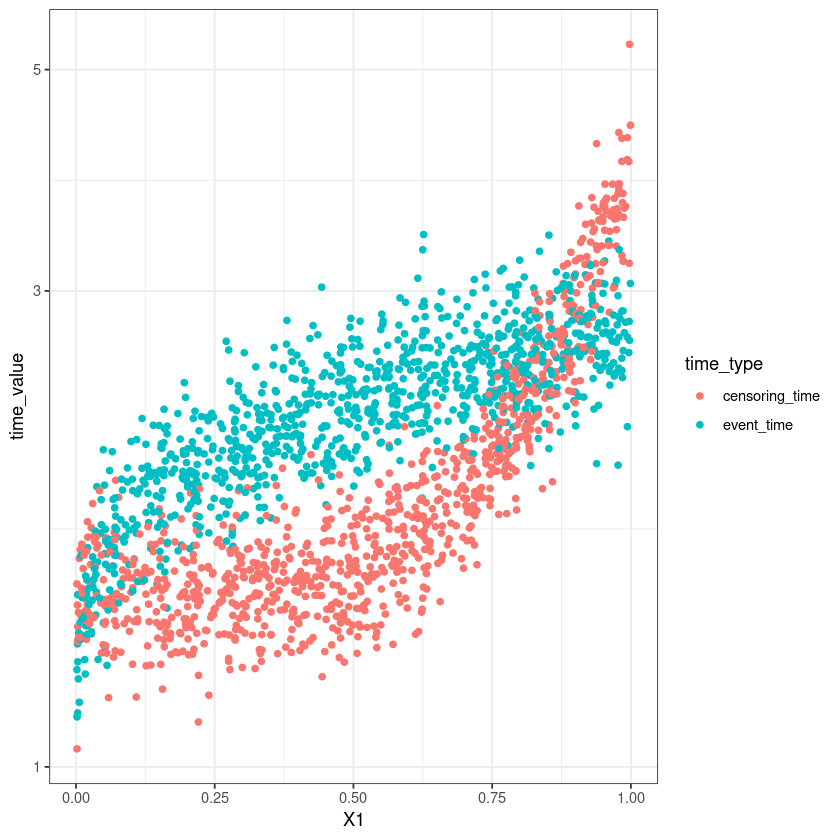

In [4]:
data.test.oracle |>
    select(X1, event_time, censoring_time) |>
    pivot_longer(cols = c(event_time, censoring_time), 
                 names_to = "time_type", values_to = "time_value") |>
    ggplot(aes(x=X1, y=time_value, color=time_type)) +
    geom_point() +
    scale_y_continuous(trans='log10') +
    theme_bw()

Suppose we know the true (oracle) data distribution. Then, we can compute the "ideal" oracle lower prediction bounds for the survival time, and evaluate them.
This will serve as an ideal benchmark for all methods.

In [5]:
source("../conf_surv/utils_conformal.R")

alpha = 0.1

pred.oracle.fast <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle.fast,
                event_time=data.test.oracle$event_time)

Mean lower bound,Coverage (event time)
<dbl>,<dbl>
1.991142,0.917


## Explore the data (practically)

Let's take a look at the data that we would normally see under type-I censoring. We focus on the training data here.

In [6]:
# Summarize data under type-I censoring
data.train.oracle |>
    summarise(Observations=n(), Events = sum(status), 
              `Proportion censored`=mean(status==0),
              `Median event time`=median(event_time),
              `Mean event time`=mean(event_time),
              `Median censoring time`=median(censoring_time),
              `Mean censoring time`=mean(censoring_time),
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]),
              `Median censoring time` = median(censoring_time))

Observations,Events,Proportion censored,Median event time,Mean event time,Median censoring time,Mean censoring time,Median observed time,Median observed event time
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,194,0.806,2.280583,2.255813,1.666057,1.917958,1.657766,1.414748


We can also plot the Kaplan-Meier curve

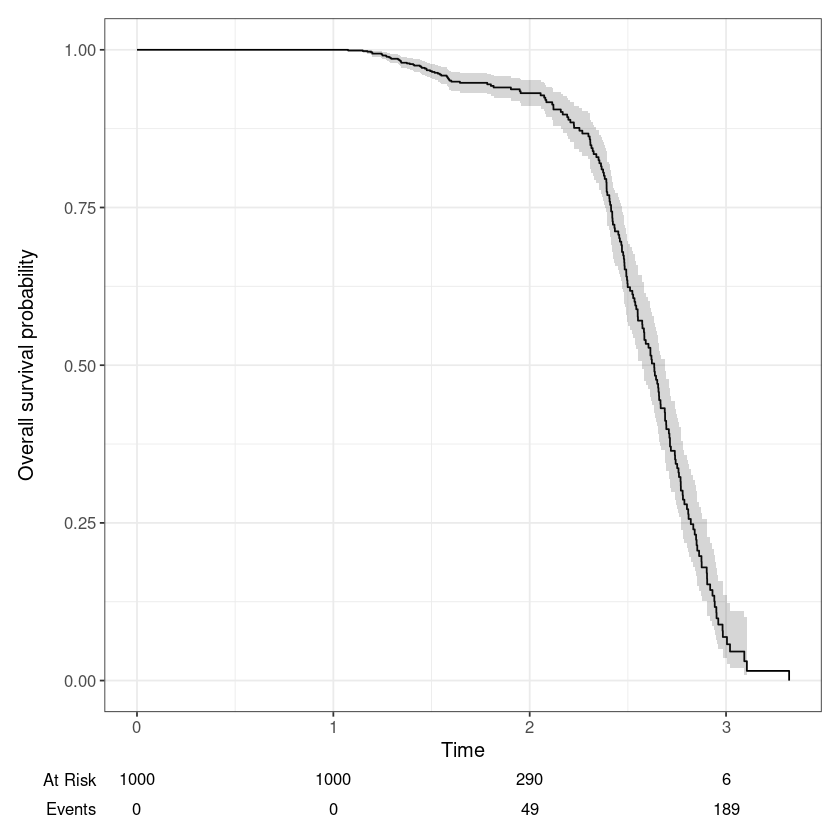

In [7]:
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Training (survival model)

Fit a survival model using the training data.

In [8]:
source("../conf_surv/utils_survival.R")

model_type = "grf"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="lognormal")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else if (model_type=="cox") {
    # Instantiate random forest survival model
    surv_model <- CoxphModelWrapper$new()
} else {
    stop("Unknown model type!")
}

surv_model$fit(Surv(time, status) ~ ., data = data.train)

Let us now visualize the predicted survival curves for two individuals.

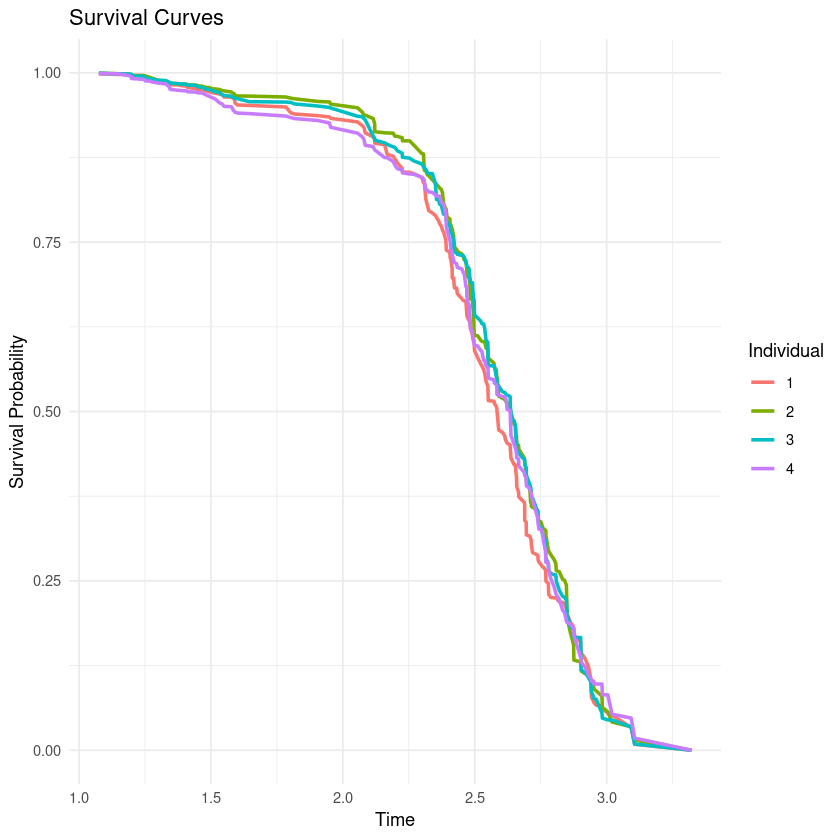

In [9]:
source("../conf_surv/utils_plotting.R")

idx.predict <- c(1:4)
predictions = surv_model$predict(data.cal[idx.predict,])
plot_survival_curves(predictions)

Predict survival time quantiles

In [10]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

,Q10%,Q50%,Q90%
,<dbl>,<dbl>,<dbl>
Individual_1,2.121003,2.591019,2.942413
Individual_2,2.225987,2.637456,2.950488
Individual_3,2.158395,2.637456,2.942413
Individual_4,2.084742,2.635015,2.951625


## Training (censoring model)

Let's start by visualizing the true censoring distribution

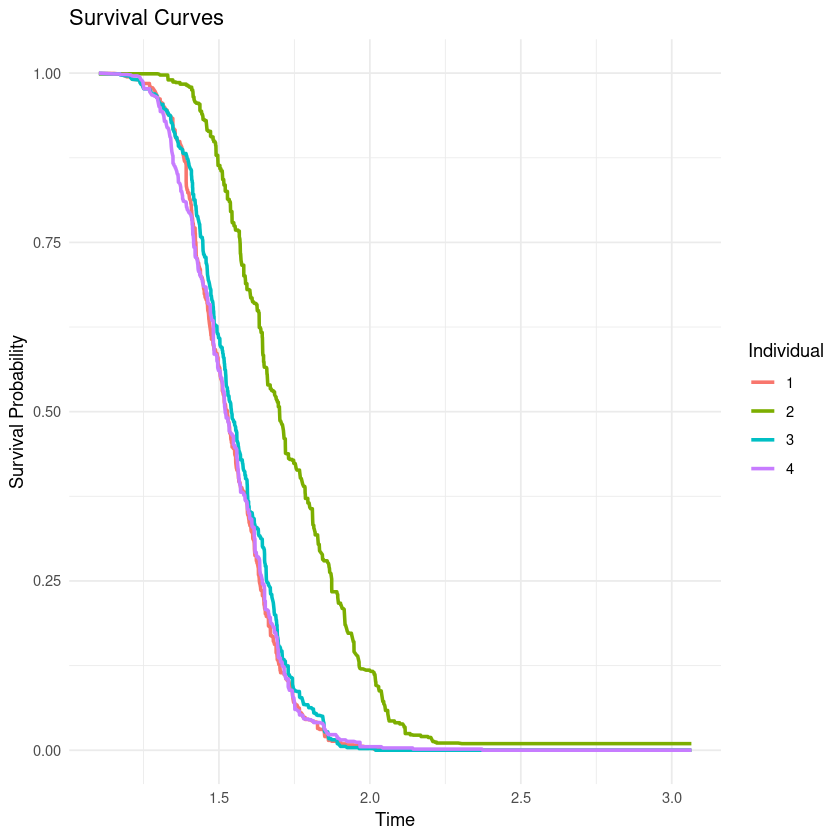

In [11]:
source("../conf_surv/utils_censoring.R")

# List of covariates to use for censoring model
# If we have prior information that some covariates are useless, we can drop them. This helps avoid overfitting, improving the performance of our prototype.
num_feat_censor <- 10
use.covariates <- paste("X",1:min(num_features,num_feat_censor),sep="")

# Initialize a base model for the censoring distribution
cens_base_model <- GRF_SurvivalForestWrapper$new(use_covariates=use.covariates)
#cens_base_model <- SurvregModelWrapper$new(dist="lognormal", use_covariates=use.covariates)
#cens_base_model <- CoxphModelWrapper$new(use_covariates=use.covariates)
#cens_base_model <- randomForestSRC_SurvivalWrapper$new(use_covariates=use.covariates)

# Create an instance of the CensoringModel class with the model
cens_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring distribution
cens_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1:4)
pred_surv = cens_model$model$predict(data.cal[idx.predict,])
plot_survival_curves(pred_surv)

## Constructing lower prediction bounds with different methods

In [12]:
# Nominal level
alpha <- 0.1

In [13]:
# Oracle prediction bounds
pred.oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle,
                event_time=data.test.oracle$event_time,
                oracle = pred.oracle,
                method="Oracle")

Method,Mean lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>
Oracle,1.991142,0.917


In [14]:
# No calibration (trust the survival model's output)
pred.nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]

evaluate_bounds(data.test$time, 
                pred.nominal,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="None")

Method,Mean lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>
None,2.128764,0.66


In [15]:
# Naive CQR
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="Naive CQR")

Method,Mean lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>
Naive CQR,1.371457,1


In [16]:
source("../conf_surv/utils_decensoring.R")

## Fit the Kaplan-Meier survival model
surv_object <- survival::Surv(time = data.train$time, event = data.train$status)
km_fit <- survfit(surv_object ~ 1)

# Qi et al.'s method (CQR with KM decensoring)
pred.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)

evaluate_bounds(data.test.oracle$time, 
                pred.decensor,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="Qi et al.")

Method,Mean lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>
Qi et al.,2.156294,0.634


In [17]:
# Prototype (combined with Gui's approach)
pred.proto <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive")

evaluate_bounds(data.test$time, 
                pred.proto,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="Prototype (Gui)")

Method,Mean lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>
Prototype (Gui),1.929464,0.887


In [18]:
# Prototype (combined with Candes' approach)
pred.proto.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")

evaluate_bounds(data.test$time, 
                pred.proto.candes,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="Prototype (Candes)")

Method,Mean lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>
Prototype (Candes),1.530765,0.997


## Run simple experiments

In [19]:
analyze_data <- function(data.train, data.cal, data.test, 
                         surv_model, cens_model, generator=NULL) {
    
    # Initialize the censoring model
    cens_model <- CensoringModel$new(model = cens_base_model)
    
    # Fit the survival model on the training data
    surv_model$fit(Surv(time, status) ~ ., data = data.train)
    
    # Fit the censoring model on the training data
    cens_model$fit(data = data.train)
    
    # Apply all methods
    predictions <- c()
    
    # Construct oracle lower bound
    if(!is.null(generator)) {
        predictions$oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]
    }
    
    # Construct nominal lower bound
    predictions$nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]
    
    # Apply naive CQR
    predictions$cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

    # Apply CQR with de-censoring (Qi et al.)
    predictions$cqr.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
       
    # Apply prototype (Gui)
    predictions$prototype.gui <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive-cqr", 
                                                   finite_sample_correction=FALSE)

    # Apply prototype (Candes)
    predictions$prototype.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")
    
    return(predictions)
}

predictions <- analyze_data(data.train, data.cal, data.test, surv_model, censoring_model, generator=generator)

In [20]:
results <- do.call(rbind, lapply(names(predictions), function(name) {
    res = evaluate_bounds(data.test$time, predictions[[name]], 
                          event_time=data.test.oracle$event_time,
                          oracle=predictions$oracle)
    
  cbind(Method = name, res)
}))
results

Method,Mean lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>
oracle,1.991142,0.917
nominal,2.128023,0.653
cqr,1.382577,1.000
cqr.decensor,2.160167,0.619
prototype.gui,1.892764,0.891
prototype.candes,1.543314,0.997
